### Install dependencies

In [1]:
pip install tensorflow scikit-learn pandas matplotlib prettytable gensim --quiet

Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import gensim
import time
import tensorflow as tf

from prettytable import PrettyTable

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


### Load and split dataset with Word2Vec embeddings

In [ ]:
# Load dense
X_train_dense, X_test_dense, y_train_dense, y_test_dense, w2v_train, w2v_test = pd.read_pickle("pickles/dense.pkl")

In [10]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_dense, y_train_dense, test_size=0.8, random_state=42)

### Scaling and encoding

In [11]:
# One-hot encode labels 
encoder = LabelBinarizer()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.fit_transform(y_val)
y_test_enc = encoder.fit_transform(y_test_dense)

In [12]:
# Scale the w2w feature vectors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test_dense)

### Build and train the Word2Vec MLP classifier

In [29]:
model = keras.models.Sequential([
    keras.layers.Dense(64, input_shape=(300,), activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])

# Define the early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

# Train the model with early stopping
%time history = model.fit(X_train_scaled, y_train_enc, batch_size = 32, epochs = 100, validation_data = (X_val_scaled, y_val_enc), callbacks = [early_stop])

Epoch 1/100
960/960 [==============================] - 17s 15ms/step - loss: 1.3188 - accuracy: 0.5350 - val_loss: 1.0648 - val_accuracy: 0.6214
Epoch 2/100
960/960 [==============================] - 14s 15ms/step - loss: 1.0976 - accuracy: 0.6077 - val_loss: 1.0266 - val_accuracy: 0.6352
Epoch 3/100
960/960 [==============================] - 14s 15ms/step - loss: 1.0414 - accuracy: 0.6277 - val_loss: 1.0267 - val_accuracy: 0.6366
Epoch 4/100
960/960 [==============================] - 14s 14ms/step - loss: 1.0183 - accuracy: 0.6362 - val_loss: 1.0059 - val_accuracy: 0.6429
Epoch 5/100
960/960 [==============================] - 14s 15ms/step - loss: 1.0044 - accuracy: 0.6418 - val_loss: 1.0106 - val_accuracy: 0.6437
Epoch 6/100
960/960 [==============================] - 14s 14ms/step - loss: 0.9861 - accuracy: 0.6468 - val_loss: 0.9983 - val_accuracy: 0.6466
Epoch 7/100
960/960 [==============================] - 14s 15ms/step - loss: 0.9752 - accuracy: 0.6504 - val_loss: 1.0041 - val_ac

### Training evaluation

**Loss**

3838/3838 - 8s - loss: 0.9673 - accuracy: 0.6570 - 8s/epoch - 2ms/step


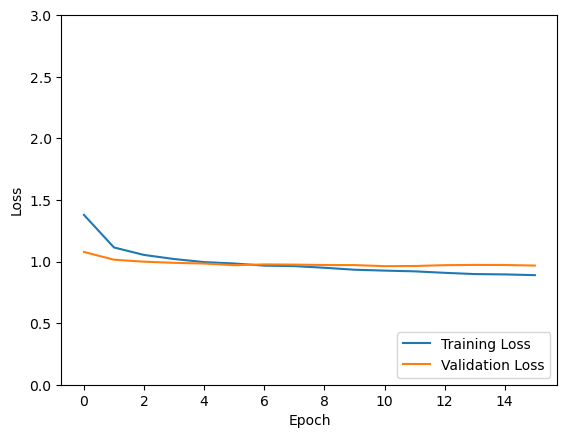

In [27]:
# Evaluate loss (train vs. val)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])
#plt.xticks(np.arange(0, +1, 5.0))
plt.legend(loc='lower right')

validation_loss, validation_acc = model.evaluate(X_val_scaled,  y_val_enc, verbose=2)

### Predict and evaluate performance on test set (out-of-sample)

**Predict on the test set**

In [22]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test_scaled)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_enc, axis=1)

3571/3571 [==============================] - 4s 1ms/step


**Confusion matrix**

In [23]:
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_labels, y_pred)

# Create PrettyTable table object
table = PrettyTable()
table.field_names = ["", "Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]

# Add the rows to the table
for i in range(len(confusion_mtx)):
    row = ["Class " + str(i)]
    row.extend(confusion_mtx[i])
    table.add_row(row)

# Print the confusion matrix table 
print(table)

+---------+---------+---------+---------+---------+---------+---------+
|         | Class 0 | Class 1 | Class 2 | Class 3 | Class 4 | Class 5 |
+---------+---------+---------+---------+---------+---------+---------+
| Class 0 |  31076  |   1738  |   2053  |   3848  |   1535  |   775   |
| Class 1 |   2689  |  23581  |   1239  |   2139  |   1646  |   819   |
| Class 2 |   716   |   438   |   4633  |   581   |   252   |   498   |
| Class 3 |   3901  |   1521  |   1373  |  15668  |   1279  |   452   |
| Class 4 |   1459  |   793   |   835   |   1502  |   2182  |   712   |
| Class 5 |   168   |   131   |   375   |   162   |   178   |   1309  |
+---------+---------+---------+---------+---------+---------+---------+


**Classification report**

In [24]:
from sklearn.metrics import classification_report
from prettytable import PrettyTable

# Generate the classification report
class_report = classification_report(y_test_labels, y_pred, output_dict=True)

# Create the PrettyTable
table = PrettyTable()
table.field_names = ['Class', 'Precision', 'Recall', 'F1-score', 'Support']

# Loop through each class in the classification report and add its metrics to the table
for class_name, metrics in class_report.items():
    if class_name.isnumeric():
        class_id = int(class_name)
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([class_id, precision, recall, f1_score, support])

# Add the macro and weighted averages to the table
macro_precision = round(class_report['macro avg']['precision'], 2)
macro_recall = round(class_report['macro avg']['recall'], 2)
macro_f1_score = round(class_report['macro avg']['f1-score'], 2)
table.add_row(['macro avg', macro_precision, macro_recall, macro_f1_score, ''])

weighted_precision = round(class_report['weighted avg']['precision'], 2)
weighted_recall = round(class_report['weighted avg']['recall'], 2)
weighted_f1_score = round(class_report['weighted avg']['f1-score'], 2)
table.add_row(['weighted avg', weighted_precision, weighted_recall, weighted_f1_score, ''])

# Print the table
print(table)


+--------------+-----------+--------+----------+---------+
|    Class     | Precision | Recall | F1-score | Support |
+--------------+-----------+--------+----------+---------+
|      0       |    0.78   |  0.76  |   0.77   |  41025  |
|      1       |    0.84   |  0.73  |   0.78   |  32113  |
|      2       |    0.44   |  0.65  |   0.53   |   7118  |
|      3       |    0.66   |  0.65  |   0.65   |  24194  |
|      4       |    0.31   |  0.29  |   0.3    |   7483  |
|      5       |    0.29   |  0.56  |   0.38   |   2323  |
|  macro avg   |    0.55   |  0.61  |   0.57   |         |
| weighted avg |    0.71   |  0.69  |   0.69   |         |
+--------------+-----------+--------+----------+---------+
